# NLP Project
# AI Detection

## Loading libraries

In [59]:
! pip install datasets

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression, LogisticRegression

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.utils import resample
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis (EDA) & Preprocessing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB


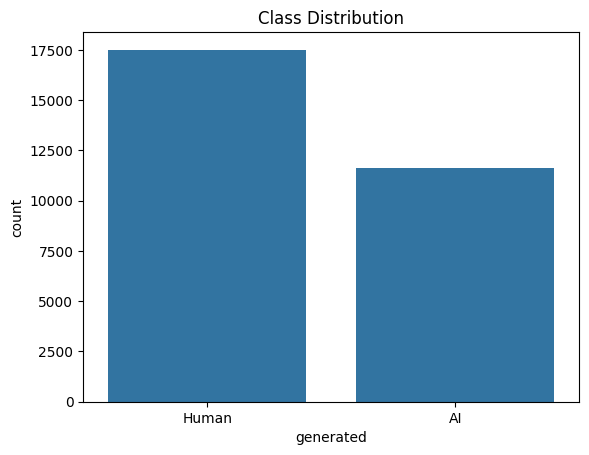

In [62]:
# Load dataset
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/IA653_Final_Project/Training_Essay_Data.csv')

# View basic info
data.info()
data['generated'] = data['generated'].astype(int)

# Check for missing values
data.isnull().sum()
# Drop rows with missing text data
data.dropna(subset=['text'], inplace=True)

# Plot data distribution to check for imbalance
sns.countplot(x='generated', data=data)
plt.title('Class Distribution')
labels = {0: "Human", 1: "AI"}
plt.xticks(ticks=[0, 1], labels=[labels[0], labels[1]])
plt.show()


## Words and Vocabulary


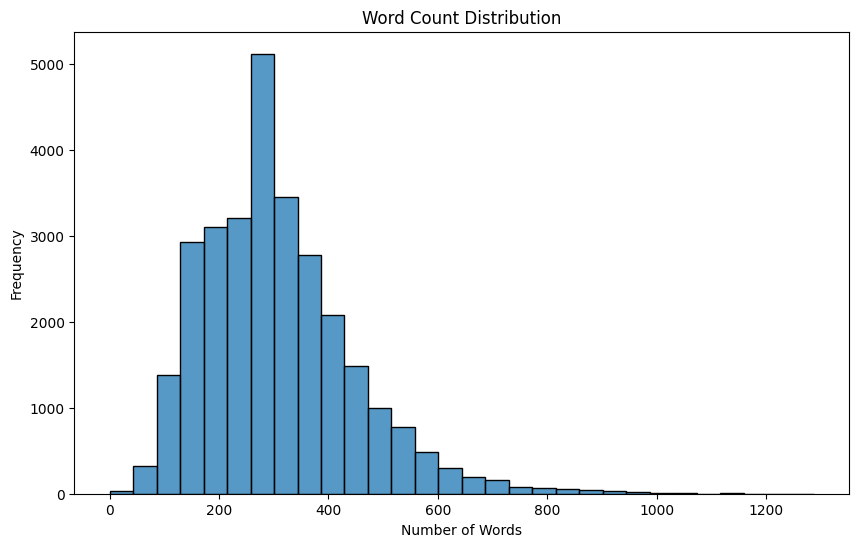

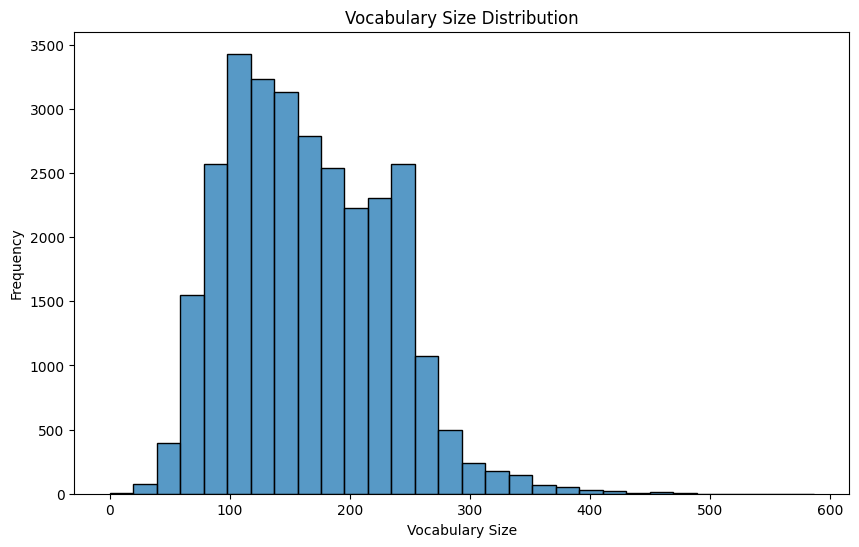

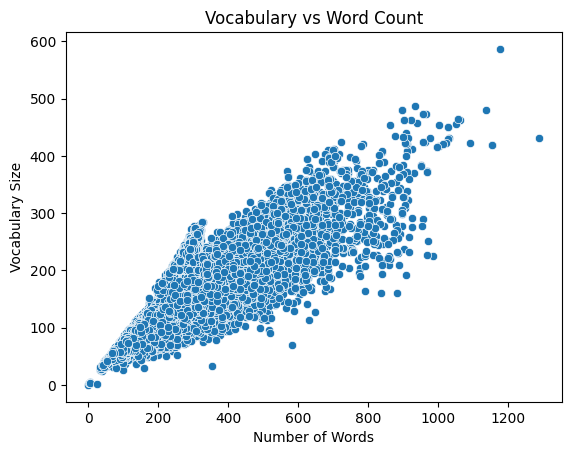

<ipython-input-63-216c32db3386>:45: RuntimeWarning: divide by zero encountered in log
  log_words = np.log(n_words)
<ipython-input-63-216c32db3386>:46: RuntimeWarning: divide by zero encountered in log
  log_vocab = np.log(n_vocab)


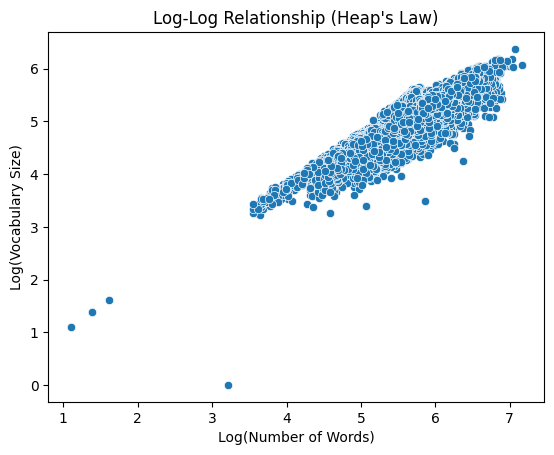

In [63]:
# Function to calculate vocabulary size and total word count
def get_vocab_and_words(text):
    word_regex = re.compile(r'\b[A-Za-z]{3,}\b')  # Match words with 3+ letters
    words = word_regex.findall(text)
    v = len(set(words))  # Vocabulary size
    n = len(words)       # Total words
    return v, n

n_words = []
n_vocab = []

# Calculate vocabulary size and word count for each text entry
for text in data['text']:
    v, n = get_vocab_and_words(text)
    n_vocab.append(v)
    n_words.append(n)

data['vocab_size'] = n_vocab
data['word_count'] = n_words

# word count distribution
plt.figure(figsize=(10,6))
sns.histplot(data['word_count'], bins=30)
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# vocabulary size distribution
plt.figure(figsize=(10,6))
sns.histplot(data['vocab_size'], bins=30)
plt.title('Vocabulary Size Distribution')
plt.xlabel('Vocabulary Size')
plt.ylabel('Frequency')
plt.show()

# Scatter plot for vocabulary vs. word count
sns.scatterplot(x=n_words, y=n_vocab)
plt.title("Vocabulary vs Word Count")
plt.xlabel("Number of Words")
plt.ylabel("Vocabulary Size")
plt.show()

# Log-log plot for Heap's Law
log_words = np.log(n_words)
log_vocab = np.log(n_vocab)
sns.scatterplot(x=log_words, y=log_vocab)
plt.title("Log-Log Relationship (Heap's Law)")
plt.xlabel("Log(Number of Words)")
plt.ylabel("Log(Vocabulary Size)")
plt.show()


## Text Normalization

                                                text  \
0  Car-free cities have become a subject of incre...   
1  Car Free Cities  Car-free cities, a concept ga...   
2    A Sustainable Urban Future  Car-free cities ...   
3    Pioneering Sustainable Urban Living  In an e...   
4    The Path to Sustainable Urban Living  In an ...   

                                     normalized_text  \
0  city become subject increasing interest debate...   
1  car free city city concept gaining traction co...   
2  sustainable urban future city emerging powerfu...   
3  pioneering sustainable urban living era marked...   
4  path sustainable urban living age rapid urbani...   

                                           sentences  
0  [Car-free cities have become a subject of incr...  
1  [Car Free Cities  Car-free cities, a concept g...  
2  [  A Sustainable Urban Future  Car-free cities...  
3  [  Pioneering Sustainable Urban Living  In an ...  
4  [  The Path to Sustainable Urban Living  In an..

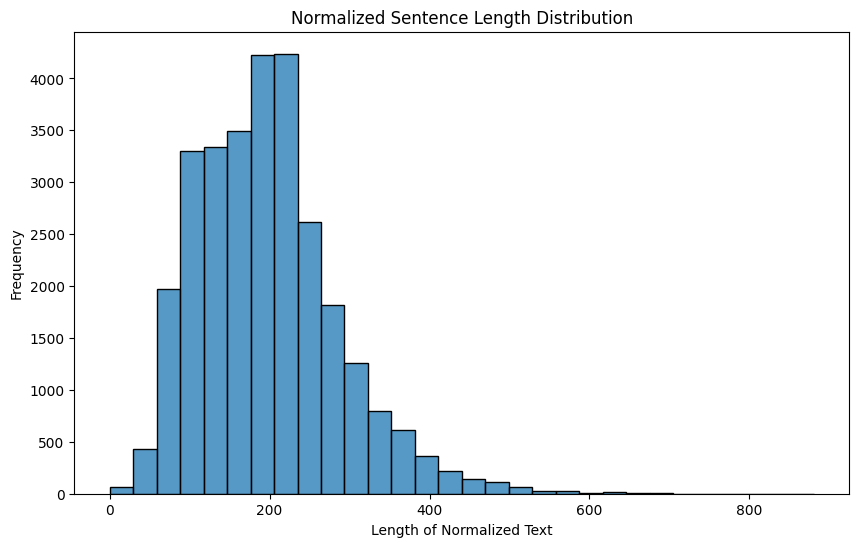

In [64]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to normalize text: tokenize, lowercase, remove stopwords, and lemmatize
def normalize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Convert to lowercase, remove punctuation and stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]  # Remove punctuation and stopwords

    # Lemmatize the tokens (converting them to their base form)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize each word

    # Return the cleaned text as a string
    normalized_text = ' '.join(tokens)

    return normalized_text

# Function to segment sentences
def segment_sentences(text):
    # Segment the text into sentences using NLTK's sentence tokenizer
    sentences = sent_tokenize(text)
    return sentences

# Apply normalization to the entire dataset
data['normalized_text'] = data['text'].apply(normalize_text)

# Apply sentence segmentation to the entire dataset
data['sentences'] = data['text'].apply(segment_sentences)

# Display the first few rows of the normalized text and segmented sentences
print(data[['text', 'normalized_text', 'sentences']].head())

# Plot sentence length distribution of normalized text
data['normalized_text_length'] = data['normalized_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(data['normalized_text_length'], bins=30)
plt.title('Normalized Sentence Length Distribution')
plt.xlabel('Length of Normalized Text')
plt.ylabel('Frequency')
plt.show()


## N-grams

<ipython-input-65-9ba04fd59093>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=ai_bigram_df, palette='Blues_d')
<ipython-input-65-9ba04fd59093>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=human_bigram_df, palette='Oranges_d')
<ipython-input-65-9ba04fd59093>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Trigram', data=ai_trigram_df, palette='Blues_d')
<ipython-input-65-9ba04fd59093>:59: FutureWarning: 

Passing `palette` without assigning `hue` is d

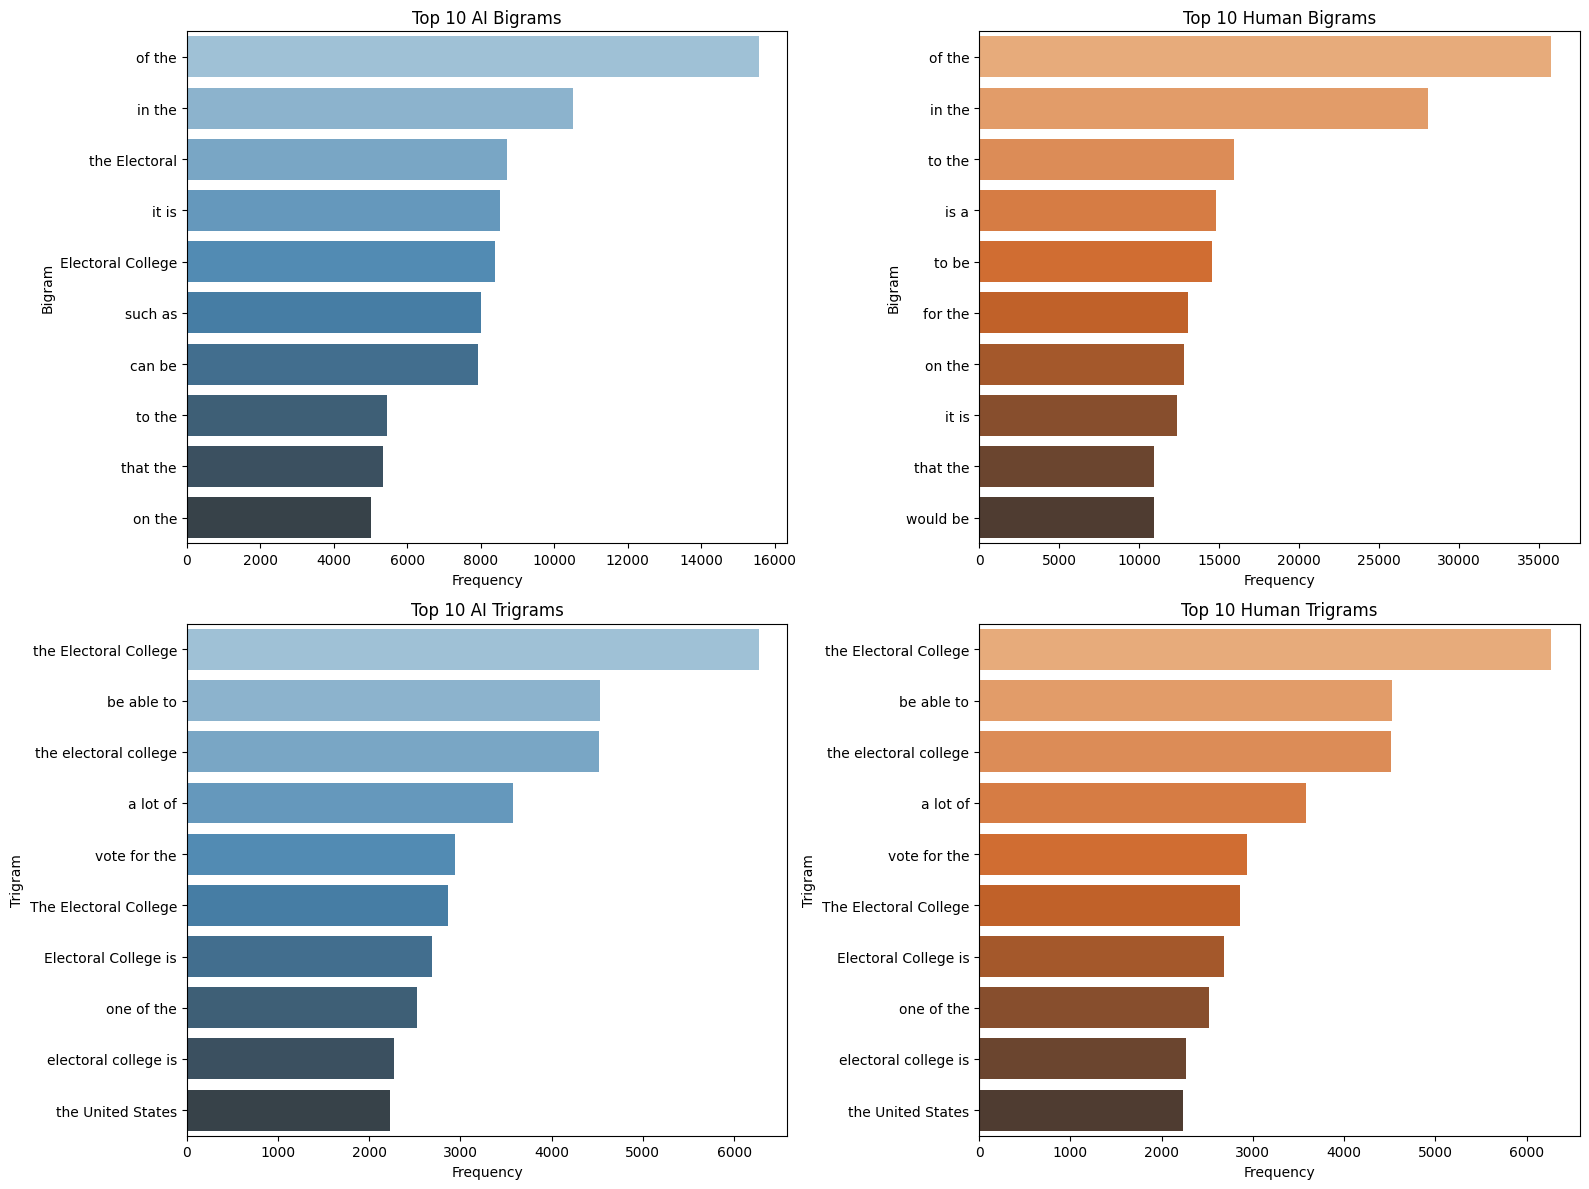

In [65]:
# Function to extract n-grams (both bigrams and trigrams)
def get_ngrams(text, n=2):
    tokens = text.split()  # Simple tokenization by spaces
    n_grams = ngrams(tokens, n)
    return [' '.join(ngram) for ngram in n_grams]

# Apply bigram and trigram extraction for both categories
data['bigrams'] = data['text'].apply(lambda x: get_ngrams(x, n=2))
data['trigrams'] = data['text'].apply(lambda x: get_ngrams(x, n=3))

# Separate data into categories
ai_bigrams = [bigram for sublist in data[data['generated'] == 1]['bigrams'] for bigram in sublist]
human_bigrams = [bigram for sublist in data[data['generated'] == 0]['bigrams'] for bigram in sublist]

ai_trigrams = [trigram for sublist in data[data['generated'] == 0]['trigrams'] for trigram in sublist]
human_trigrams = [trigram for sublist in data[data['generated'] == 0]['trigrams'] for trigram in sublist]

# Count frequency of bigrams and trigrams using Counter
ai_bigram_counts = Counter(ai_bigrams)
human_bigram_counts = Counter(human_bigrams)

ai_trigram_counts = Counter(ai_trigrams)
human_trigram_counts = Counter(human_trigrams)

# Get the top 10 most common bigrams and trigrams for AI and Human categories
top_ai_bigrams = ai_bigram_counts.most_common(10)
top_human_bigrams = human_bigram_counts.most_common(10)

top_ai_trigrams = ai_trigram_counts.most_common(10)
top_human_trigrams = human_trigram_counts.most_common(10)

# Convert results to DataFrames for easy visualization
ai_bigram_df = pd.DataFrame(top_ai_bigrams, columns=['Bigram', 'Frequency'])
human_bigram_df = pd.DataFrame(top_human_bigrams, columns=['Bigram', 'Frequency'])

ai_trigram_df = pd.DataFrame(top_ai_trigrams, columns=['Trigram', 'Frequency'])
human_trigram_df = pd.DataFrame(top_human_trigrams, columns=['Trigram', 'Frequency'])

# Plot bigrams and trigrams for AI and Human categories
plt.figure(figsize=(16, 12))

# Plot AI bigrams
plt.subplot(2, 2, 1)
sns.barplot(x='Frequency', y='Bigram', data=ai_bigram_df, palette='Blues_d')
plt.title('Top 10 AI Bigrams')

# Plot Human bigrams
plt.subplot(2, 2, 2)
sns.barplot(x='Frequency', y='Bigram', data=human_bigram_df, palette='Oranges_d')
plt.title('Top 10 Human Bigrams')

# Plot AI trigrams
plt.subplot(2, 2, 3)
sns.barplot(x='Frequency', y='Trigram', data=ai_trigram_df, palette='Blues_d')
plt.title('Top 10 AI Trigrams')

# Plot Human trigrams
plt.subplot(2, 2, 4)
sns.barplot(x='Frequency', y='Trigram', data=human_trigram_df, palette='Oranges_d')
plt.title('Top 10 Human Trigrams')

plt.tight_layout()
plt.show()


## Balancing the data by undersampling

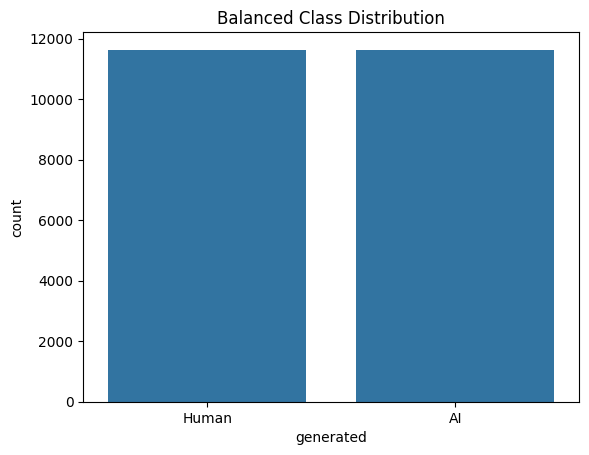

In [66]:
# Separate majority and minority classes
human_data = data[data['generated'] == 0]
ai_data = data[data['generated'] == 1]

# Undersample the majority class (human)
human_downsampled = resample(human_data,
                             replace=False,  # Sample without replacement
                             n_samples=len(ai_data),  # Match minority class size
                             random_state=42)  # For reproducibility

# Combine the minority class (AI) with the downsampled majority class
balanced_data = pd.concat([human_downsampled, ai_data])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify class distribution
sns.countplot(x='generated', data=balanced_data)
plt.title('Balanced Class Distribution')
plt.xticks(ticks=[0, 1], labels=["Human", "AI"])
plt.show()


## Creating Word Embeddings using Word2Vec


In [67]:
# Tokenize text into words
balanced_data['tokens'] = balanced_data['normalized_text'].apply(word_tokenize)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=balanced_data['tokens'],
                          vector_size=100,  # Dimensionality of word vectors
                          window=5,         # Context window size
                          min_count=2,      # Ignore words with total frequency < 2
                          workers=4,        # Number of threads
                          sg=0)             # CBOW model (use sg=1 for Skip-gram)

# Save the Word2Vec model
word2vec_model.save("word2vec_model")

# Check most similar words
print(word2vec_model.wv.most_similar("ai", topn=10))


[('robotics', 0.7817942500114441), ('intelligence', 0.7649307250976562), ('automation', 0.7537289261817932), ('printing', 0.7463868260383606), ('sophisticated', 0.7406389117240906), ('robotic', 0.7320824861526489), ('iot', 0.7219666242599487), ('predictive', 0.721413254737854), ('application', 0.7070462703704834), ('analytics', 0.6884872913360596)]


## Visualizing Word Embeddings with PCA


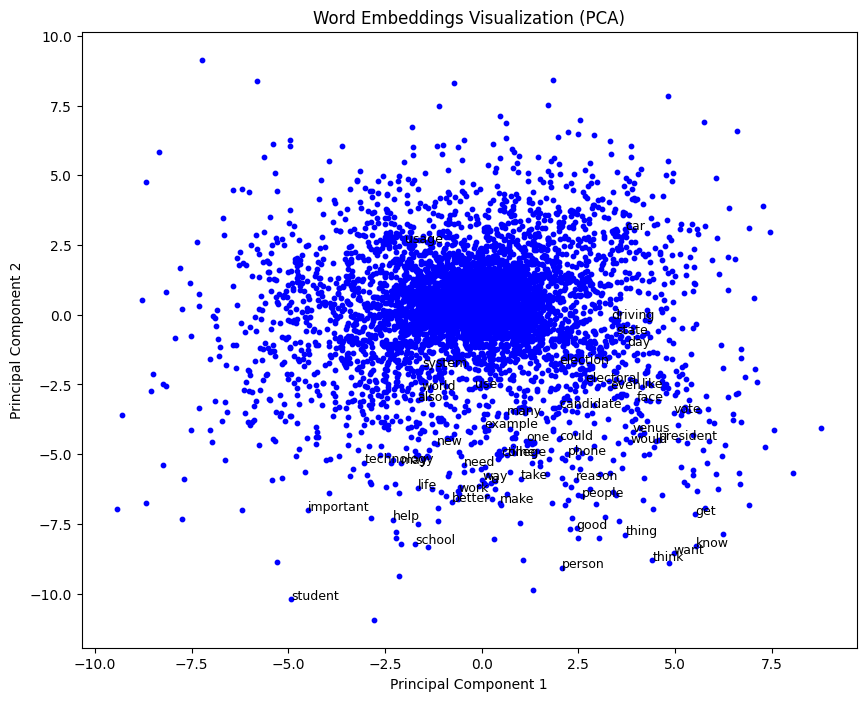

In [68]:
# Extract word vectors
word_vectors = word2vec_model.wv
vocab = list(word_vectors.index_to_key)
X = word_vectors[vocab]

# Reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', s=10, color='blue')
for i, word in enumerate(vocab[:50]):  # Show top 50 words for readability
    plt.annotate(word, xy=(X_pca[i, 0], X_pca[i, 1]), fontsize=9)
plt.title("Word Embeddings Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


## Using Embeddings as Features


In [69]:
def document_vector(tokens, model):
    """Compute the mean vector for a document"""
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Compute document vectors for the balanced dataset
balanced_data['doc_vector'] = balanced_data['tokens'].apply(lambda x: document_vector(x, word2vec_model))

# Prepare feature matrix and target variable
X = np.stack(balanced_data['doc_vector'].values)
y = balanced_data['generated']

# Check feature matrix shape
print("Feature matrix shape:", X.shape)


Feature matrix shape: (23274, 100)


# Naive Bayes vs Logistic Regression

### Naive Bayes

In [70]:
# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_tfidf = tfidf.fit_transform(balanced_data['normalized_text'])

# Split dataset
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes Results")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes Results
Accuracy: 0.9600429645542428
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2301
           1       0.97      0.95      0.96      2354

    accuracy                           0.96      4655
   macro avg       0.96      0.96      0.96      4655
weighted avg       0.96      0.96      0.96      4655



### Logistic Regression

In [71]:
# Split dataset
X_train_docvec, X_test_docvec, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_docvec, y_train)

# Predictions and evaluation
y_pred_lr = lr_model.predict(X_test_docvec)
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results
Accuracy: 0.9757250268528465
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2301
           1       0.98      0.97      0.98      2354

    accuracy                           0.98      4655
   macro avg       0.98      0.98      0.98      4655
weighted avg       0.98      0.98      0.98      4655



### Metrics Comparison

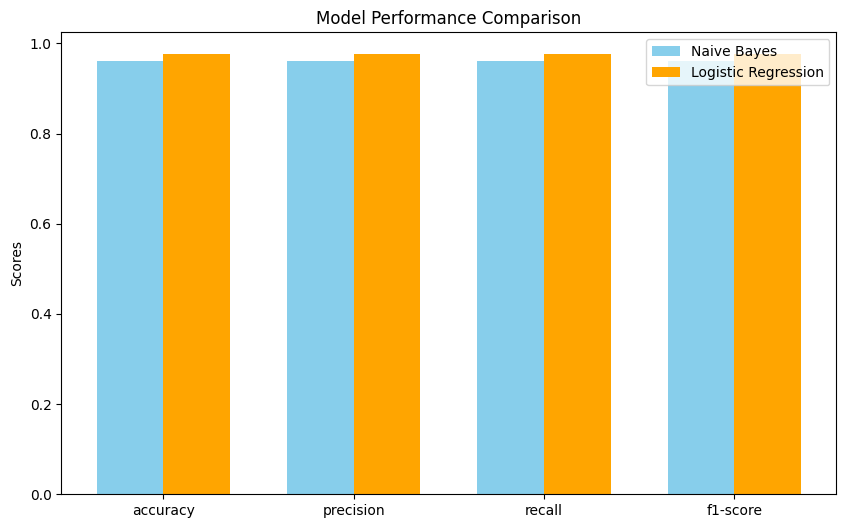

In [72]:
nb_report = classification_report(y_test, y_pred_nb, output_dict=True)
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)

# Convert the dictionary into a DataFrame for easier access
nb_df = pd.DataFrame(nb_report).transpose()
lr_df = pd.DataFrame(lr_report).transpose()

# Extract metrics for the "weighted avg" row
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
nb_scores = [accuracy_score(y_test, y_pred_nb), nb_df.loc['weighted avg', 'precision'],
             nb_df.loc['weighted avg', 'recall'], nb_df.loc['weighted avg', 'f1-score']]

lr_scores = [accuracy_score(y_test, y_pred_lr), lr_df.loc['weighted avg', 'precision'],
             lr_df.loc['weighted avg', 'recall'], lr_df.loc['weighted avg', 'f1-score']]

# Plot the metrics
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, nb_scores, width, label='Naive Bayes', color='skyblue')
plt.bar(x + width/2, lr_scores, width, label='Logistic Regression', color='orange')

plt.xticks(x, metrics)
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


### Confusion Matrix Comparison

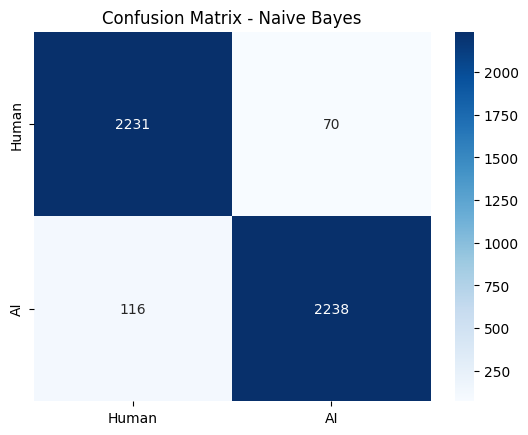

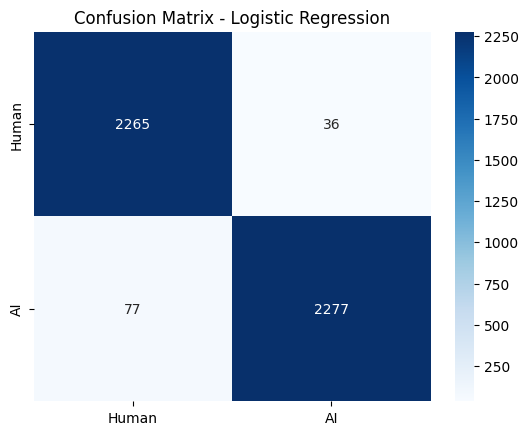

In [80]:
# Confusion Matrix for Naive Bayes
cm_nn = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# Confusion Matrix for Logistic Regression
cm_lstm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Neural Networks

### Basic Feedforward Neural Network

In [74]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
model_basic = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_nn = model_basic.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

# Evaluate the model
y_pred_nn = (model_basic.predict(X_test) > 0.5).astype("int32")
print("Neural Network Results")
print(classification_report(y_test, y_pred_nn))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


466/466 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9184 - loss: 0.2068 - val_accuracy: 0.9780 - val_loss: 0.0750
Epoch 2/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9753 - loss: 0.0779 - val_accuracy: 0.9785 - val_loss: 0.0651
Epoch 3/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9802 - loss: 0.0627 - val_accuracy: 0.9828 - val_loss: 0.0565
Epoch 4/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9829 - loss: 0.0564 - val_accuracy: 0.9850 - val_loss: 0.0531
Epoch 5/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9842 - loss: 0.0522 - val_accuracy: 0.9844 - val_loss: 0.0548
Epoch 6/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9856 - loss: 0.0464 - val_accuracy: 0.9823 - val_loss: 0.0505
Epoch 7/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9863 - loss: 0.0429 - val_accuracy: 0.9882 - val_loss: 0.0368
Epoch 8/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9878 - loss: 0.0360 - val_accuracy: 0.9831 - val_

#### Loss Curve

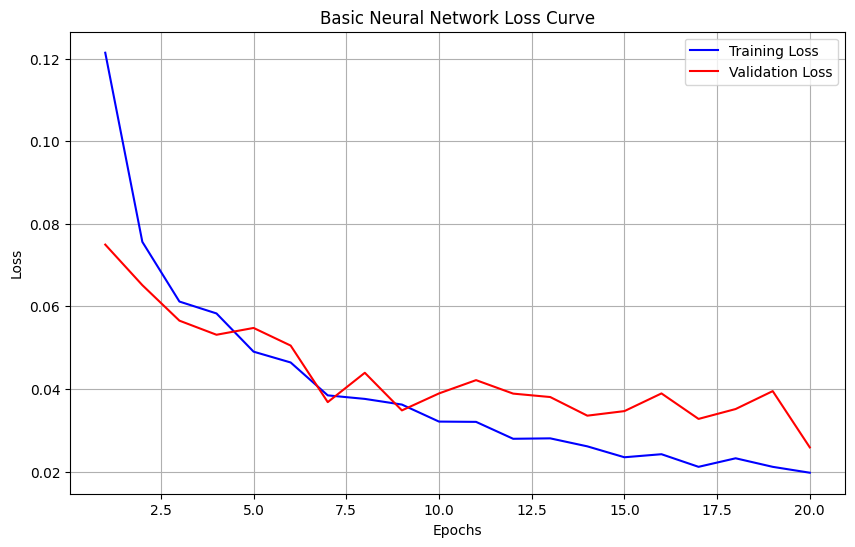

In [75]:
# Extract the training and validation loss values
train_loss_nn = history_nn.history['loss']
val_loss_nn = history_nn.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_loss_nn, label='Training Loss', color='blue')
plt.plot(range(1, 21), val_loss_nn, label='Validation Loss', color='red')
plt.title('Basic Neural Network Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### LSTM

In [76]:
# Tokenize the normalized text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Adjust num_words if needed
tokenizer.fit_on_texts(balanced_data['normalized_text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(balanced_data['normalized_text'])

# Pad sequences to ensure uniform input size
max_length = 128  # Adjust based on average text length
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Labels
y = balanced_data['generated'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameters
vocab_size = 10000  # Same as the tokenizer's num_words
embedding_dim = 128
input_length = max_length

# Define the LSTM model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    LSTM(128, return_sequences=False),  # You can try GRU here instead
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model_lstm.summary()

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_split=0.2,  # Further split training data for validation
    epochs=5,              # Adjust based on resources and overfitting
    batch_size=32,         # Adjust based on memory availability
    verbose=1
)

# Evaluate on test data
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predict on test data
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred_lstm))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
466/466 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7734 - loss: 0.4828 - val_accuracy: 0.9723 - val_loss: 0.0878
Epoch 2/5
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9615 - loss: 0.1270 - val_accuracy: 0.9834 - val_loss: 0.0669
Epoch 3/5
466/466 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9868 - loss: 0.0552 - val_accuracy: 0.9842 - val_loss: 0.0573
Epoch 4/5
466/466 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9907 - loss: 0.0381 - val_accuracy: 0.9834 - val_loss: 0.0605
Epoch 5/5
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9892 - loss: 0.0391 - val_accuracy: 0.9858 - val_loss: 0.0525
Test Accuracy: 0.9850
Test Loss: 0.0693
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2301
           1       0.99      0.98      0.99      2354

    accuracy                           0.98      4655
   macro avg       0.98      0.99      0.98      4655
weighte

#### Loss Curve

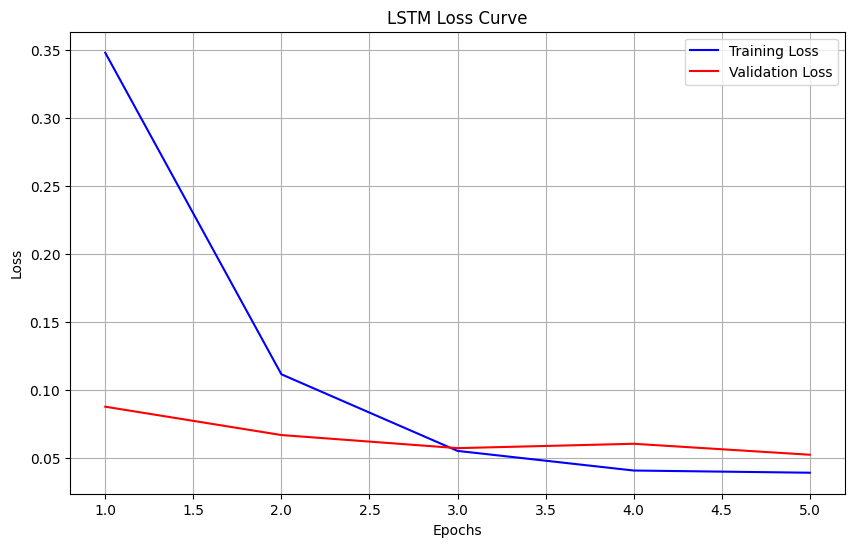

In [77]:
# Extract the training and validation loss values
train_loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), train_loss_lstm, label='Training Loss', color='blue')
plt.plot(range(1, 6), val_loss_lstm, label='Validation Loss', color='red')
plt.title('LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Metrics Comparison

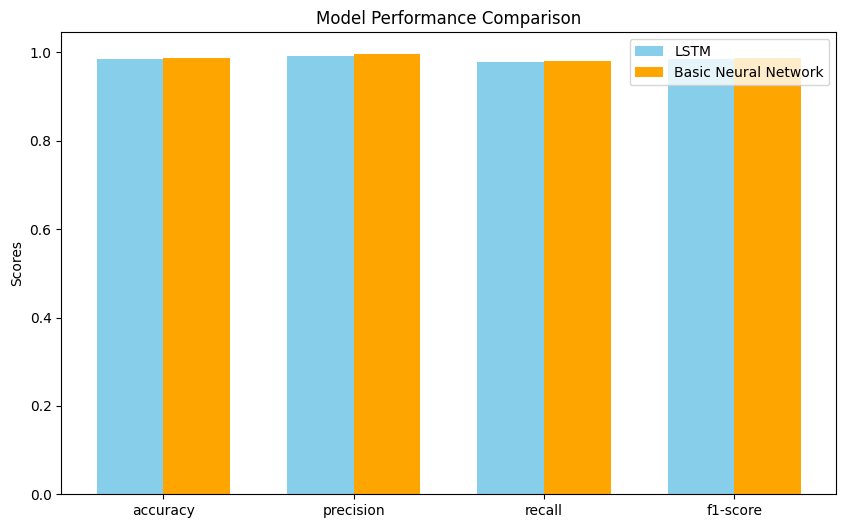

In [78]:
def get_metrics(y_true, y_pred, model_name):
    metrics = {
        'Model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1-score': f1_score(y_true, y_pred)
    }
    return metrics

# LSTM Predictions
lstm_metrics = get_metrics(y_test, y_pred_lstm, "LSTM")

# Basic Neural Network Predictions
nn_metrics = get_metrics(y_test, y_pred_nn, "Basic Neural Network")

# Metrics for each model (Accuracy, Precision, Recall, F1-Score)
metrics = ['accuracy', 'precision', 'recall', 'f1-score']

lstm_scores = [lstm_metrics['accuracy'], lstm_metrics['precision'], lstm_metrics['recall'], lstm_metrics['f1-score']]
nn_scores = [nn_metrics['accuracy'], nn_metrics['precision'], nn_metrics['recall'], nn_metrics['f1-score']]

# Bar width for side-by-side comparison
x = np.arange(len(metrics))
width = 0.35

# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, lstm_scores, width, label='LSTM', color='skyblue')
plt.bar(x + width/2, nn_scores, width, label='Basic Neural Network', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


### Confusion Matrix Comparison

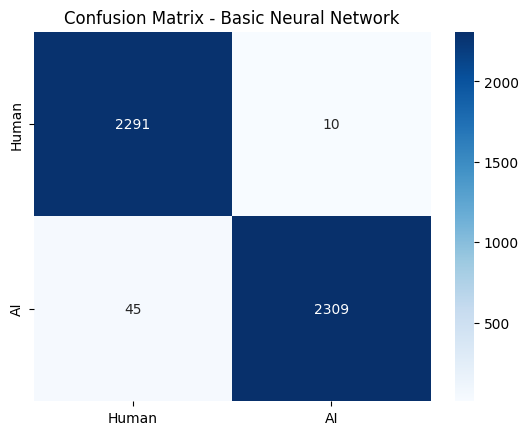

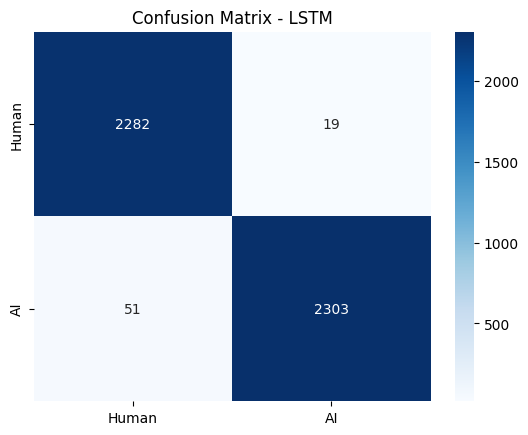

In [79]:
# Confusion Matrix for NN
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - Basic Neural Network")
plt.show()

# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix - LSTM")
plt.show()